In [ ]:
!pip install opencv-python numpy imageio scipy

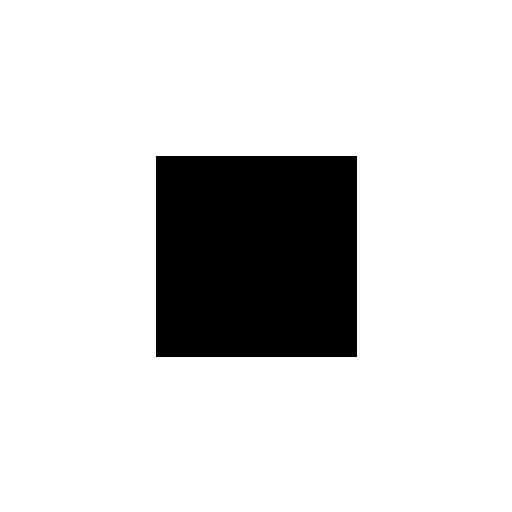

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow # Import the cv2_imshow function


img = np.ones((512, 512), dtype=np.uint8) * 255  # White background
cv2.rectangle(img, (156, 156), (356, 356), (0, 0, 0), -1)  # Black square

cv2.imwrite("shape2.png", img)  # Save the image
cv2_imshow(img)  # Use cv2_imshow instead of cv2.imshow
cv2.waitKey(0)
cv2.destroyAllWindows()


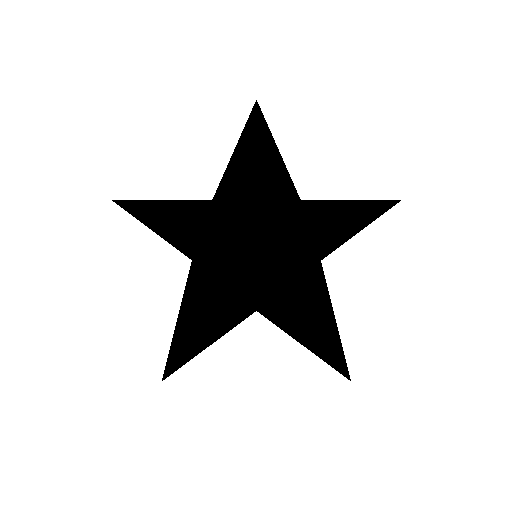

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Import cv2_imshow

img = np.ones((512, 512), dtype=np.uint8) * 255  # White background
pts = np.array([[256, 100], [300, 200], [400, 200], [320, 260], [350, 380],
                [256, 310], [162, 380], [192, 260], [112, 200], [212, 200]], np.int32)
pts = pts.reshape((-1, 1, 2))
cv2.fillPoly(img, [pts], (0, 0, 0))  # Black star

cv2.imwrite("star_shape.png", img)
cv2_imshow(img)  # Use cv2_imshow instead of cv2.imshow
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np
import imageio
from scipy.spatial import Delaunay

def get_contour_shape(frame):
    """Detects and extracts the largest contour (user-drawn shape)."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        return max(contours, key=cv2.contourArea).reshape(-1, 2)
    return None

def delaunay_triangulation(points):
    """Computes Delaunay triangulation for the shape."""
    return Delaunay(points)

def warp_triangle(img1, img2, t1, t2):
    """Warps a triangular region from one shape to another."""
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    t1_rect = t1 - r1[:2]
    t2_rect = t2 - r2[:2]

    mask = np.zeros((r2[3], r2[2], 3), dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(t2_rect), (1, 1, 1), 16, 0)

    img1_rect = img1[r1[1]:r1[1]+r1[3], r1[0]:r1[0]+r1[2]]
    size = (r2[2], r2[3])

    warp_mat = cv2.getAffineTransform(np.float32(t1_rect), np.float32(t2_rect))
    img2_rect = cv2.warpAffine(img1_rect, warp_mat, size, None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * (1 - mask) + img2_rect * mask

def morph_shapes(live_shape, target_shape, steps=10):
    """Blends the live shape with a predefined target shape in real-time."""
    tri = delaunay_triangulation(live_shape)

    for alpha in np.linspace(0, 1, steps):
        intermediate = np.zeros((480, 640, 3), dtype=np.uint8)
        interpolated_points = (1 - alpha) * live_shape + alpha * target_shape

        for simplex in tri.simplices:
            t1 = live_shape[simplex]
            t2 = interpolated_points[simplex]
            warp_triangle(np.zeros((480, 640, 3), dtype=np.uint8), intermediate, t1, t2)

        cv2.imshow("Shape Morphing", intermediate)
        cv2.waitKey(50)

# Load predefined shape (e.g., a triangle)
target_shape = np.array([[300, 100], [100, 400], [500, 400]], np.int32)

cap = cv2.VideoCapture(0)  # Open webcam

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale and detect shape
    user_shape = get_contour_shape(frame)

    if user_shape is not None and len(user_shape) > 10:  # Minimum points needed
        morph_shapes(user_shape, target_shape)

    cv2.imshow("Webcam", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


/content/shape_blending.py

In [ ]:
pip install numpy opencv-python dlib imageio


In [ ]:
pip install opencv-python dlib imutils numpy scipy imageio matplotlib


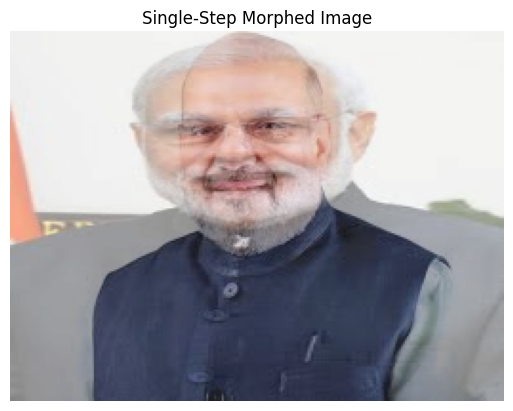

✅ Saved: morphed_single_image.jpg


In [ ]:
import cv2
import numpy as np
import imageio
import matplotlib.pyplot as plt

# Load the two images
img1 = cv2.imread("/content/amit.jpg")
img2 = cv2.imread("/content/modi.jpg")

# Validate image loading
if img1 is None or img2 is None:
    raise ValueError("One or both image paths are incorrect or missing.")

# Resize second image to match the first image size
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# Blending factor (0.5 = equal contribution from both)
alpha = 0.5

# Create the blended (morphed) image
blended = cv2.addWeighted(img1, 1 - alpha, img2, alpha, 0)

# Convert BGR to RGB for correct display in matplotlib
blended_rgb = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)

# Show the result
plt.imshow(blended_rgb)
plt.axis("off")
plt.title("Single-Step Morphed Image")
plt.show()

# Save the output
cv2.imwrite("morphed_single_image.jpg", blended)
print("✅ Saved: morphed_single_image.jpg")




In [ ]:
import cv2
import numpy as np
import imageio
import matplotlib.pyplot as plt

# Load images
img1 = cv2.imread("/content/anu.jpg")  # Your photo
img2 = cv2.imread("/content/sam.jpg")  # Robot photo

# Resize images to match dimensions
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# List to store frames for GIF
frames = []
num_frames = 50  # Number of transition steps

plt.figure(figsize=(6, 6))
for i in range(num_frames):
    alpha = i / num_frames  # Blending factor
    blended = cv2.addWeighted(img1, 1 - alpha, img2, alpha, 0)

    # Convert BGR to RGB (for displaying correctly)
    blended_rgb = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)
    frames.append(blended_rgb)

    # Show animation frame-by-frame
    plt.clf()
    plt.imshow(blended_rgb)
    plt.axis("off")
    plt.pause(0.05)

# Save as GIF
imageio.mimsave("morphing.gif", frames, duration=0.05)

print("GIF saved as 'morphing.gif' 🎥")
plt.show()


Output hidden; open in https://colab.research.google.com to view.

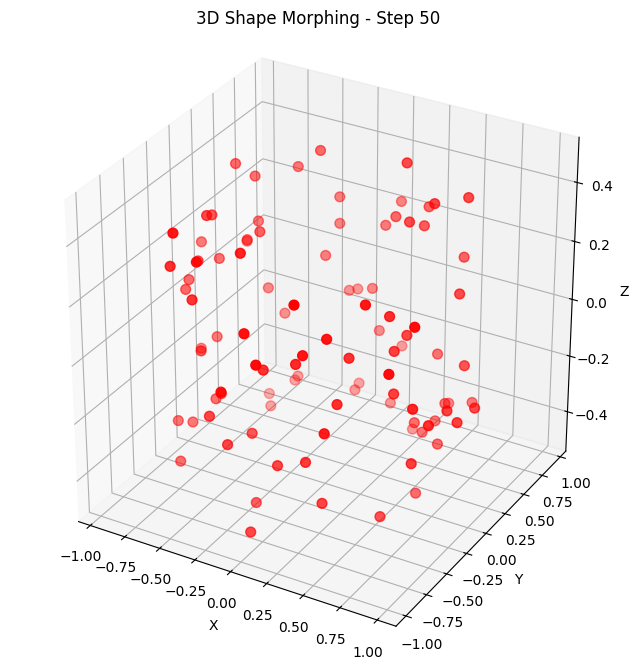

Unique 3D Morphing animation saved as 'unique_3d_shape_morphing.gif'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# Function to generate random 3D points (a randomized shape)
def generate_random_3d_shape(num_points=50):
    angles = np.linspace(0, 2 * np.pi, num_points)
    x = np.sin(angles) * np.random.uniform(0.5, 1, num_points)
    y = np.cos(angles) * np.random.uniform(0.5, 1, num_points)
    z = np.random.uniform(-0.5, 0.5, num_points)
    return np.column_stack((x, y, z))

# Generate two random 3D shapes (for morphing)
shape1 = generate_random_3d_shape(100)
shape2 = generate_random_3d_shape(100)

# Function to generate intermediate steps between two 3D shapes with non-linear interpolation
def generate_intermediate_steps_3d(shape1, shape2, num_frames=50):
    steps = []
    for t in np.linspace(0, 1, num_frames):
        # Apply non-linear interpolation using a sine function for a more dynamic transition
        t = np.sin(t * np.pi / 2)  # Smooth out the interpolation using sine
        intermediate_shape = (1 - t) * shape1 + t * shape2
        steps.append(intermediate_shape)
    return steps

# Generate intermediate shapes
steps = generate_intermediate_steps_3d(shape1, shape2)

# Initialize the figure for 3D plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Animation function
def animate_3d(frame):
    ax.clear()  # Clear previous frame
    t = frame / 50  # Transition factor
    intermediate_shape = (1 - t) * shape1 + t * shape2
    ax.scatter(intermediate_shape[:, 0], intermediate_shape[:, 1], intermediate_shape[:, 2], color='r', s=50)
    ax.set_title(f"3D Shape Morphing - Step {frame+1}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_box_aspect([1, 1, 1])  # Equal scaling

# Create the animation
ani = animation.FuncAnimation(fig, animate_3d, frames=50, interval=100, blit=False)

# Save animation as GIF
ani.save("unique_3d_shape_morphing.gif", writer="pillow")

plt.show()

print("Unique 3D Morphing animation saved as 'unique_3d_shape_morphing.gif'")


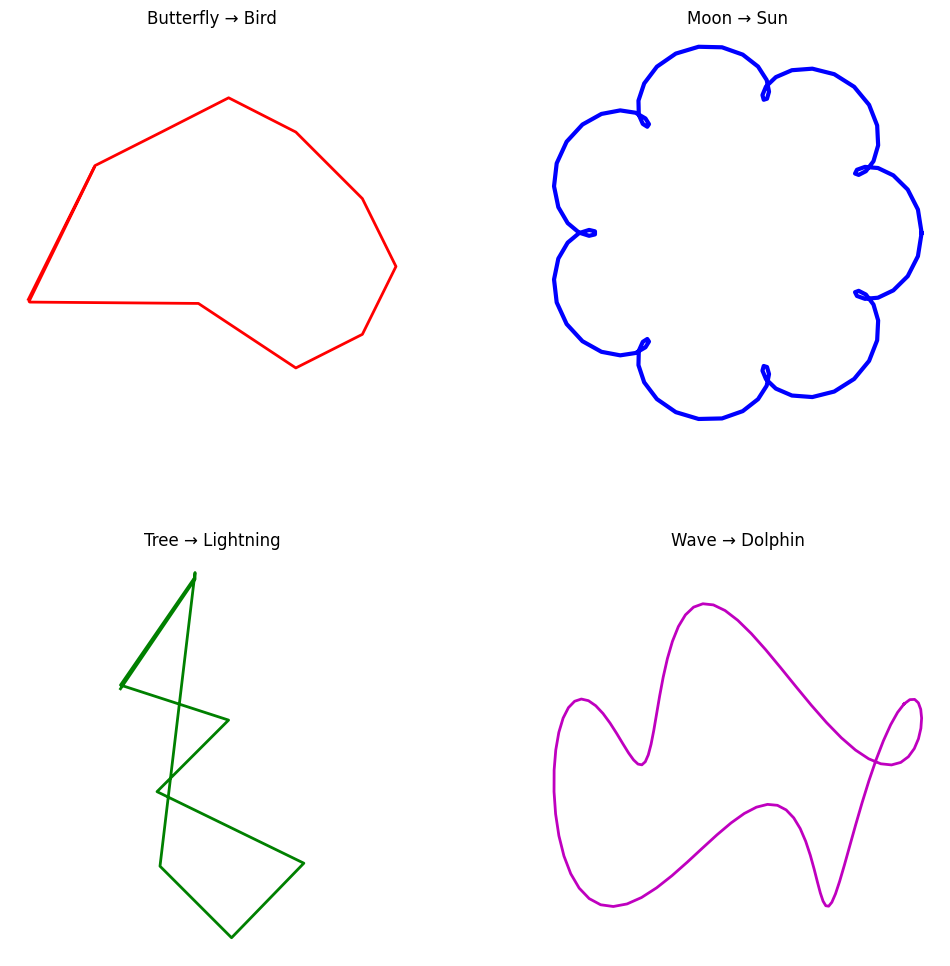

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Input: Define your shapes (each shape is a series of 2D coordinates)
# Butterfly → Bird Example
shape1_butterfly = np.array([[-0.4, 0], [-0.3, 0.3], [-0.2, 0.4], [0, 0.6],
                             [0.2, 0.4], [0.3, 0.3], [0.4, 0], [0.3, -0.3],
                             [0.2, -0.4], [0.4, -0.6], [-0.2, -0.4], [-0.3, -0.3], [-0.4, 0]])
shape2_bird = np.array([[-0.5, 0], [-0.3, 0.4], [-0.1, 0.5], [0.1, 0.6], [0.3, 0.5],
                        [0.5, 0.3], [0.6, 0.1], [0.5, -0.1], [0.3, -0.2], [0, 0], [-0.5, 0]])

# Moon → Sun
shape1_moon = np.column_stack((0.5 * np.cos(np.linspace(0, 2 * np.pi, 100)) - 0.2 * np.cos(2 * np.linspace(0, 2 * np.pi, 100)),
                               0.5 * np.sin(np.linspace(0, 2 * np.pi, 100))))
shape2_sun = np.column_stack((0.6 * np.cos(np.linspace(0, 2 * np.pi, 100)) + 0.1 * np.cos(8 * np.linspace(0, 2 * np.pi, 100)),
                              0.6 * np.sin(np.linspace(0, 2 * np.pi, 100)) + 0.1 * np.sin(8 * np.linspace(0, 2 * np.pi, 100))))

# Tree → Lightning
shape1_tree = np.array([[-0.1, -0.5], [-0.1, 0], [-0.3, 0.2], [-0.1, 0.4], [0, 0.6],
                        [0.1, 0.4], [0.3, 0.2], [0.1, 0.4], [0.1, -0.5], [-0.1, -0.5]])
shape2_lightning = np.array([[0, 0.5], [-0.2, 0.2], [0.1, 0.1], [-0.1, -0.1],
                             [0.3, -0.3], [0.1, -0.5], [-0.1, -0.3], [0, 0.5]])

# Wave → Dolphin
shape1_wave = np.column_stack((0.5 * np.cos(np.linspace(0, 2 * np.pi, 100)) + 0.2 * np.cos(3 * np.linspace(0, 2 * np.pi, 100)),
                               0.5 * np.sin(np.linspace(0, 2 * np.pi, 100))))
shape2_dolphin = np.column_stack((0.5 * np.cos(np.linspace(0, 2 * np.pi, 100)) + 0.1 * np.sin(3 * np.linspace(0, 2 * np.pi, 100)),
                                  0.3 * np.sin(np.linspace(0, 2 * np.pi, 100)) + 0.2 * np.cos(4 * np.linspace(0, 2 * np.pi, 100))))

# Function to match the points in two shapes
def match_points(shape1, shape2):
    if len(shape1) > len(shape2):
        shape2 = np.vstack([shape2, shape2[:len(shape1) - len(shape2)]])
    elif len(shape1) < len(shape2):
        shape1 = np.vstack([shape1, shape1[:len(shape2) - len(shape1)]])
    return shape1, shape2

# Match points to have the same number of points in each shape
shape1_butterfly, shape2_bird = match_points(shape1_butterfly, shape2_bird)
shape1_moon, shape2_sun = match_points(shape1_moon, shape2_sun)
shape1_tree, shape2_lightning = match_points(shape1_tree, shape2_lightning)
shape1_wave, shape2_dolphin = match_points(shape1_wave, shape2_dolphin)

# Function to animate the transition between the shapes
def generate_intermediate_steps(shape1, shape2, num_frames=50):
    steps = []
    for t in np.linspace(0, 1, num_frames):
        intermediate_shape = (1 - t) * shape1 + t * shape2
        steps.append(intermediate_shape)
    return steps

# Generate intermediate shapes for each pair of shapes
steps_butterfly_bird = generate_intermediate_steps(shape1_butterfly, shape2_bird)
steps_moon_sun = generate_intermediate_steps(shape1_moon, shape2_sun)
steps_tree_lightning = generate_intermediate_steps(shape1_tree, shape2_lightning)
steps_wave_dolphin = generate_intermediate_steps(shape1_wave, shape2_dolphin)

# Initialize figure for displaying all intermediate steps
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # A 2x2 grid of subplots for intermediate steps
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Animation function
def animate(frame):
    t = frame / 50
    axes[0, 0].clear()
    axes[0, 0].plot((1 - t) * shape1_butterfly[:, 0] + t * shape2_bird[:, 0],
                    (1 - t) * shape1_butterfly[:, 1] + t * shape2_bird[:, 1], "r-", linewidth=2)
    axes[0, 0].set_title("Butterfly → Bird")
    axes[0, 0].axis("equal")
    axes[0, 0].axis("off")

    axes[0, 1].clear()
    axes[0, 1].plot((1 - t) * shape1_moon[:, 0] + t * shape2_sun[:, 0],
                    (1 - t) * shape1_moon[:, 1] + t * shape2_sun[:, 1], "b-", linewidth=3)
    axes[0, 1].set_title("Moon → Sun")
    axes[0, 1].axis("equal")
    axes[0, 1].axis("off")

    axes[1, 0].clear()
    axes[1, 0].plot((1 - t) * shape1_tree[:, 0] + t * shape2_lightning[:, 0],
                    (1 - t) * shape1_tree[:, 1] + t * shape2_lightning[:, 1], "g-", linewidth=2)
    axes[1, 0].set_title("Tree → Lightning")
    axes[1, 0].axis("equal")
    axes[1, 0].axis("off")

    axes[1, 1].clear()
    axes[1, 1].plot((1 - t) * shape1_wave[:, 0] + t * shape2_dolphin[:, 0],
                    (1 - t) * shape1_wave[:, 1] + t * shape2_dolphin[:, 1], "m-", linewidth=2)
    axes[1, 1].set_title("Wave → Dolphin")
    axes[1, 1].axis("equal")
    axes[1, 1].axis("off")

# Create animation
ani = animation.FuncAnimation(fig, animate, frames=50, interval=100, blit=False)
# Save animation as GIF
ani.save("multi_shape_morphing.gif", writer="pillow")
plt.show()
